First, edit the paths in the following cell to point to the correct locations on your system.

If you don't want to deal with the aia error tables yet, you can always ignore that line and 
set real_aia_err=False in the dem call at the end of the notebook to use a flat uncertainty. 

In [1]:
#AIA Error table - set path to location in your system.
errortab='/Users/jessieduncan/ssw/sdo/aia/response/aia_V3_error_table.txt'

#Sunpy data directory (or wherever else you store your downloaded AIA data)
sunpy_dir='/Users/jessieduncan/sunpy/data/'

#Path to top-level do-dem directory - edit for your system.
path_to_dodem = '/Users/jessieduncan/do-dem/'
from sys import path as sys_path
sys_path.append(path_to_dodem+'/dodem/')

#do-dem
import lightcurves as lc
import region_fitting as rf
import nustar_dem_prep as nu
import dodem

#Basics
import numpy as np
import importlib
import matplotlib.pyplot as plt
from astropy import units as u

#Time
import matplotlib.dates as mdates
import astropy.time
import datetime

#File wrangling
import glob
import pickle
import os
import pathlib
os.getcwd()

'/Users/jessieduncan/do-dem'

First, let's take a look at the NuSTAR lightcurves.

Using time limits:
[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]


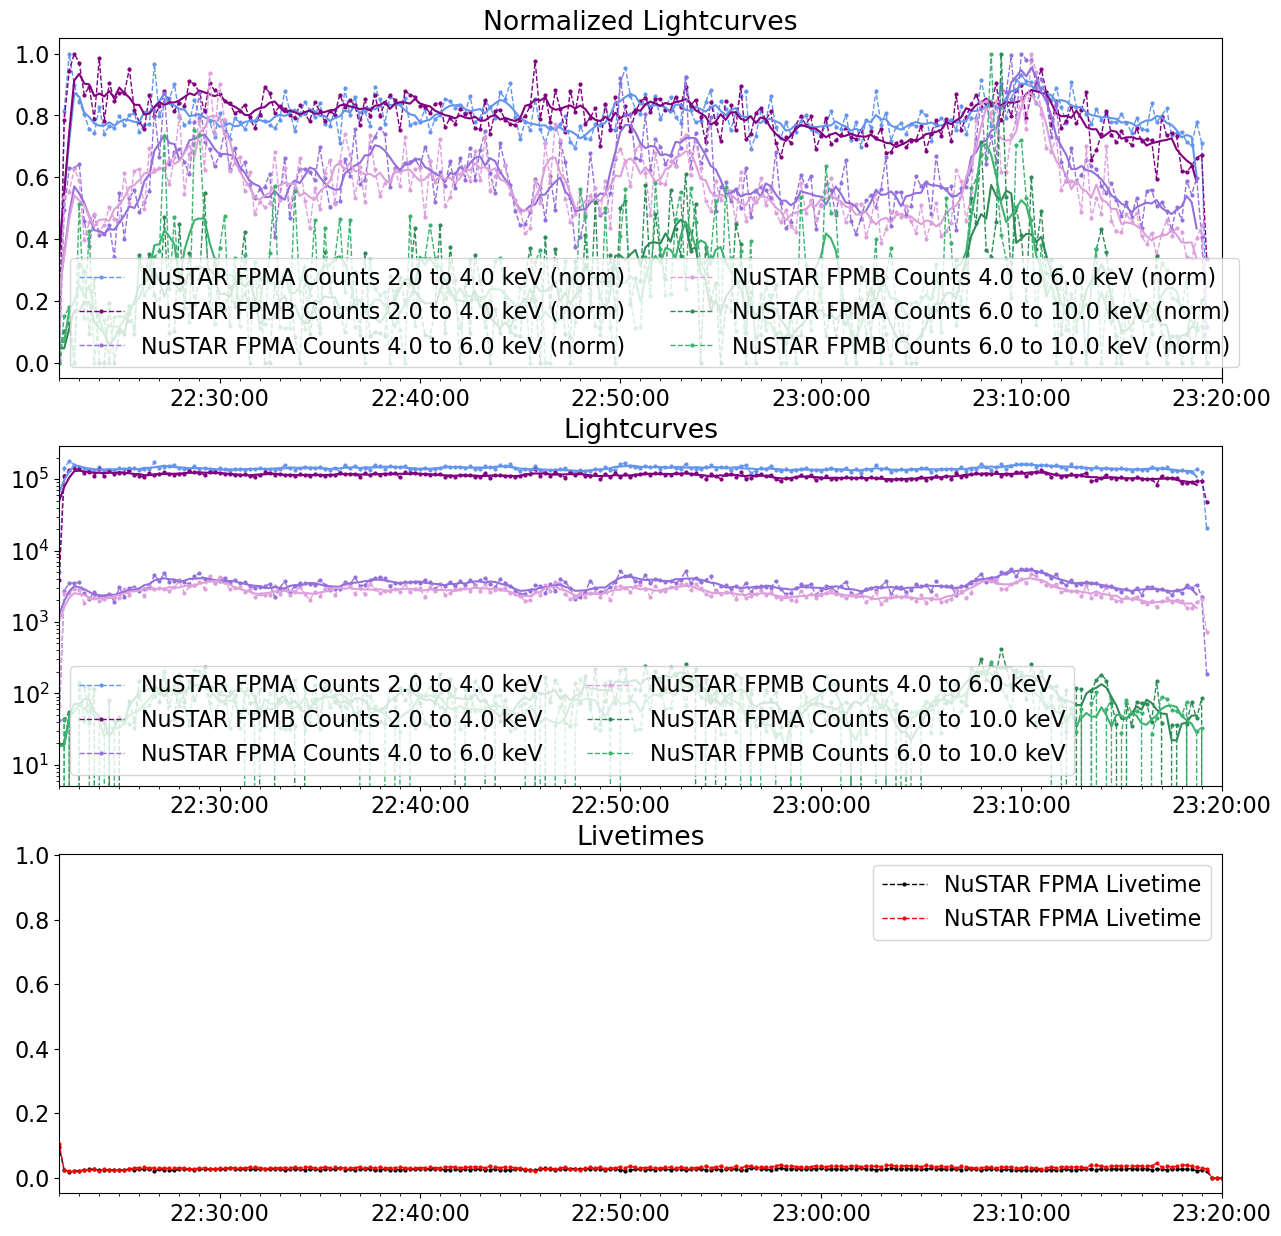

In [2]:
#Name your working directory
working_dir='./initial_dem/'

#Make a new working directory for prepped data/etc if it doesn't yet exist
save_path = pathlib.Path(working_dir)
if not save_path.exists():
    save_path.mkdir()

#Set path to obsid directory - initial pipeline should have been run already.
datapath='/Users/jessieduncan/nustar/may-2018/5_29pixpos/80410205001/'
obsid='80410205001'

#Comment second line if you're not using this same example nustar orbit
#Edit it to include only the desired time interval (default- all times in file) once you've run this once
timerange=[]
timerange=[datetime.datetime(2018, 5, 29, 22, 22), datetime.datetime(2018, 5, 29, 23, 20)]

evtA = glob.glob(datapath+'/event_cl/*A06_cl.evt')
evtB = glob.glob(datapath+'/event_cl/*B06_cl.evt')
hkA  = glob.glob(datapath+'/hk/*A_fpm.hk')
hkB  = glob.glob(datapath+'/hk/*B_fpm.hk')

importlib.reload(lc)
lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[2.,4.], 
                              livetime_corr=True, save_dir=working_dir)
lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[4.,6.], 
                              livetime_corr=True, save_dir=working_dir)
lc.prepare_nustar_lightcurves(evtA, evtB, hkA, hkB, timebin=15, erange=[6.,10.], 
                              livetime_corr=True, save_dir=working_dir)

lc.plot_nustar_lightcurves(eranges = [[2.,4.],[4.,6.],[6.,10.]],
                           timerange=timerange, save_dir=working_dir)

Now, let's pick some initial time intervals for DEMs - how about every five minutes?

Note: later, you may want to make NuSTAR-statistics informed DEM intervals. Functionality for this is in nustar_dem_prep.find_intervals().

In [3]:
# #DEFINE ONE OR MORE 'MACRO INTERVALS' AND THEN MAKE SHORTER DEM TIME INTERVALS
macro_interval = [astropy.time.Time('2018-05-29T22:22:00', scale='utc', format='isot'),
                    astropy.time.Time('2018-05-29T23:19:00', scale='utc', format='isot')]

mins=5
time_intervals=[]
checktime = macro_interval[0]
while checktime < macro_interval[1]:
    time_intervals.append([checktime, checktime+mins*u.min])
    checktime = checktime+mins*u.min
    
    
count=0    
for t in time_intervals:
    print(count, t[0].strftime('%H-%M-%S'), t[1].strftime('%H-%M-%S'))
    count+=1



0 22-22-00 22-27-00
1 22-27-00 22-32-00
2 22-32-00 22-37-00
3 22-37-00 22-42-00
4 22-42-00 22-47-00
5 22-47-00 22-52-00
6 22-52-00 22-57-00
7 22-57-00 23-02-00
8 23-02-00 23-07-00
9 23-07-00 23-12-00
10 23-12-00 23-17-00
11 23-17-00 23-22-00


Now, for the first time interval, let's find a good NuSTAR DEM region. For starters, we'll use this for AIA (and XRT, if available) as well. Note that given the NuSTAR pointing uncertainty, it's probably not the best choice for an AIA/XRT region. However, we will use it for an initial run. 

Note – this is the first cell that uses aspects of the NuSTAR pipeline. If you have not done so already, you'll need to quit the session and go back and initialize heasoft before opening this notebook. (If you don't, this will fail with an empty nuscreen_output.txt file.) 

[#################################] 100% de436.bsp


100% [............................................................................] 439880 / 439880No region fitting: using 150 arcsec circle around COM


***Warning: You do not have an up-to-date version of Xspec.init
      in your ~/.xspec directory.  It is recommended that you move
      your old Xspec.init aside and start up XSPEC again.  This will
      place a new version Xspec.init in your directory, which you may
      then modify using your old settings.
***Warning: You do not have an up-to-date version of Xspec.init
      in your ~/.xspec directory.  It is recommended that you move
      your old Xspec.init aside and start up XSPEC again.  This will
      place a new version Xspec.init in your directory, which you may
      then modify using your old settings.
***Warning: You do not have an up-to-date version of Xspec.init
      in your ~/.xspec directory.  It is recommended that you move
      your old Xspec.init aside and start up XSPEC again.  This will
      place a new version Xspec.init in your directory, which you may
      then modify using your old settings.


0.8424022003042545

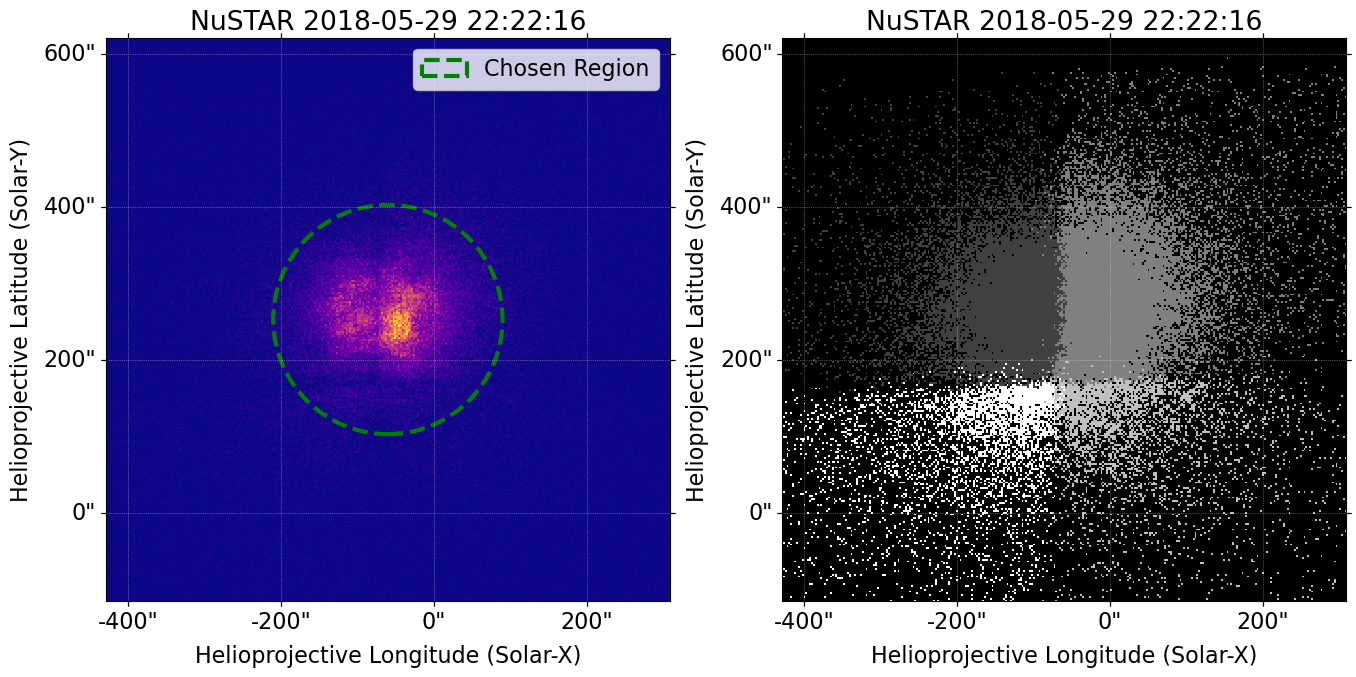

In [4]:
# importlib.reload(nu)

gtifile=datapath+'event_cl/nu'+obsid+'A06_gti.fits'
regfile=path_to_dodem+'starter_region.reg'
time_interval=time_intervals[0]

nu.make_nustar_products(time_interval, 'A', gtifile, datapath, regfile, working_dir, edit_regfile=True,
                         nofit=True, pile_up_corr=True, clobber=False, nuradius=150, path_to_dodem=path_to_dodem)

Now, we'll take the NuSTAR output region file and use it to make a dictionary that will be used to create a region object for AIA/XRT in the DEM data prep stage.

In [5]:
timestring = time_interval[0].strftime('%H-%M-%S')
stopstring = time_interval[1].strftime('%H-%M-%S')
timestring=timestring+'_'+stopstring
    
regfile=working_dir+timestring+'/nu'+obsid+'A06_0_p_cl_sunpos_COM_region.reg'
offset, rad = rf.read_regfile(regfile, time_interval[0], time_interval[1], 'hourangle')
print(offset)
print(rad)

xx = offset[0].value
yy = offset[1].value

[-60.09296956 253.1244629 ] arcsec
150.0 arcsec


In [6]:
#Set broad box for plotting (using region object)
bl=[(xx-200)*u.arcsec, (yy-200)*u.arcsec]
tr=[(xx+200)*u.arcsec,(yy+200)*u.arcsec]
print(tr[0]-bl[0], tr[1]-bl[1])

#Make region dictionary 
region_input = {'center': (xx,  yy)*u.arcsec,
                  'radius': rad}

400.0 arcsec 400.0 arcsec


Now, let's set some other DEM input parameters (chosing which instruments to use, NuSTAR DEM energies, etc).

In [7]:
#What instruments are you using?
#---------------------------------
aia=True
#---------------------------------
eis=False
#---------------------------------
xrt=False
plot=False
#Here is the exposure time limits dictionary for each XRT filter combination:
exposure_dict={'Be_thin': [1*u.s, 10*u.s],
                'Be_med': [],
              'Al_poly': [0.1*u.s, 1*u.s]}
#---------------------------------
nustar=True
#If nustar is being used, here are the chosen energy ranges:
nuenergies=[[2.5,3.5],[3.5,6.], [6.,10.]]
#---------------------------------

#---------------------------------
#---------------------------------
#What temperature range would you like to use? (units: log(T))
minT=5.6
maxT=7.2

#Would you prefer to plot temperatures in MK, or the default (logT)
plotMK=False
#---------------------------------
#---------------------------------

name='initial_dem'

Note: sometimes, when running the DEM prep for the first time, there will be issues with the AIA data download via Fido.search and .fetch. This often seems to be resolvable by just repeating the same attempted download. To save time, aia_dem_prep.aia_for_DEM() can be used in isolation (see function for needed keywords) to avoid having to run all the other instrument prep as well by running it through the full dodem function. 

This can take several minutes if you are downloading+prepping AIA data for this interval for the first time.

Start Time:  2018-05-29T22:22:00.000
Stop Time:  2018-05-29T22:27:00.000
You provided both a region box and a specific region.
Bounding box will be used only for initial data prep (will save submap instead of full disk);
specific region will be used for DEM

Less than two files ready to average (or clobber set); we will go prep more.
[94]
Waves: [94]
Results from 1 Provider:

7 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 474.522 Mbyte

       Start Time               End Time        Source Instrument  Wavelength  Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                    Angstrom                                                                       Mibyte 
----------------------- ----------------------- ------ ---------- ------------ -------- --------- -------- ------------ ------------- ----------- --------
2018-05-29 22:22:11.000 2018-05-29 22:22:1

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
Less than two files ready to average (or clobber set); we will go prep more.
[131]
Waves: [131]
Results from 1 Provider:

7 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 474.522 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2018-05-29 22:22:06.000 2018-05-29 22:22:07.000    SDO        AIA 131.0 .. 131.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2018-05-29 22:22:54.000 2018-05-29 22:22:55.0

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
Less than two files ready to average (or clobber set); we will go prep more.
[171]
Waves: [171]
Results from 1 Provider:

7 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 474.522 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2018-05-29 22:22:09.000 2018-05-29 22:22:10.000    SDO        AIA 171.0 .. 171.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2018-05-29 22:22:45.000 2018-05-29 22:22:46.0

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
Less than two files ready to average (or clobber set); we will go prep more.
[193]
Waves: [193]
Results from 1 Provider:

7 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 474.522 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2018-05-29 22:22:04.000 2018-05-29 22:22:05.000    SDO        AIA 193.0 .. 193.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2018-05-29 22:22:52.000 2018-05-29 22:22:53.0

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
Less than two files ready to average (or clobber set); we will go prep more.
[211]
Waves: [211]
Results from 1 Provider:

7 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 474.522 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2018-05-29 22:22:09.000 2018-05-29 22:22:10.000    SDO        AIA 211.0 .. 211.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2018-05-29 22:22:45.000 2018-05-29 22:22:46.0

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
Less than two files ready to average (or clobber set); we will go prep more.
[335]
Waves: [335]
Results from 1 Provider:

7 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 474.522 Mbyte

       Start Time               End Time        Source Instrument   Wavelength   Provider  Physobs  Wavetype Extent Width Extent Length Extent Type   Size  
                                                                     Angstrom                                                                        Mibyte 
----------------------- ----------------------- ------ ---------- -------------- -------- --------- -------- ------------ ------------- ----------- --------
2018-05-29 22:22:00.000 2018-05-29 22:22:01.000    SDO        AIA 335.0 .. 335.0     JSOC intensity   NARROW         4096          4096    FULLDISK 64.64844
2018-05-29 22:22:48.000 2018-05-29 22:22:49.0

Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
PREPPING MAP
No AIA response file found, so using HISSW to make one using SSWIDL aia_get_response.
IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 9389.
Licensed for use by: Space Physics Lab License

% Program caused arithmetic error: Floating illegal operand
% Compiled module: SEARCH_NETWORK.
% Compiled module: MKLOG.
% Compiled module: CHKLOG.
% Compiled module: IS_NUMBER.
% Compiled module: GET_DELIM.
% Compiled module: TRIM2.
% Compiled module: FIX_SLASH.
% Compiled module: RHESSI_SERVER.
% Compiled module: SINCE_VERSION.
% Compiled module: IS_NUMBER2.
% Compiled module: USE_NETWORK.
% Compiled module: ADD_PATH.
% Compiled module: LOCAL_NAME.
% Compiled module: EXPAND_TILDE.
% Compiled module: IS_DIR.
% Compiled module: GET_PATH_DELIM.
% Compiled module: STR_SEP.
% Compiled module: SSW_PATH.
% Com


Hey, where is the thermal emission model file? It should be called:
./initial_dem/fvth_out.dat
Let us now make a new one using hissw to run the IDL code.
IDL Version 8.5, Mac OS X (darwin x86_64 m64).
(c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 9389.
Licensed for use by: Space Physics Lab License

% Program caused arithmetic error: Floating illegal operand
% Compiled module: SEARCH_NETWORK.
% Compiled module: MKLOG.
% Compiled module: CHKLOG.
% Compiled module: IS_NUMBER.
% Compiled module: GET_DELIM.
% Compiled module: TRIM2.
% Compiled module: FIX_SLASH.
% Compiled module: RHESSI_SERVER.
% Compiled module: SINCE_VERSION.
% Compiled module: IS_NUMBER2.
% Compiled module: USE_NETWORK.
% Compiled module: ADD_PATH.
% Compiled module: LOCAL_NAME.
% Compiled module: EXPAND_TILDE.
% Compiled module: IS_DIR.
% Compiled module: GET_PATH_DELIM.
% Compiled module: STR_SEP.
% Compiled module: HISSW_PROCEDURE.
% Compiled module: F

***Warning: You do not have an up-to-date version of Xspec.init
      in your ~/.xspec directory.  It is recommended that you move
      your old Xspec.init aside and start up XSPEC again.  This will
      place a new version Xspec.init in your directory, which you may
      then modify using your old settings.
***Warning: You do not have an up-to-date version of Xspec.init
      in your ~/.xspec directory.  It is recommended that you move
      your old Xspec.init aside and start up XSPEC again.  This will
      place a new version Xspec.init in your directory, which you may
      then modify using your old settings.


ARF File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001B06_0_p_sr.arf']
RMF File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001B06_0_p_sr.rmf']
PHA File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001B06_0_p_sr.pha']

Max NuSTAR Energy:  6.199999809265137

A94 :     2.97   1.51  51 %
A131 :     23.93   4.25  18 %
A171 :     648.92   67.65  10 %
A193 :     763.14   78.70  10 %
A211 :     277.22   29.21  11 %
A335 :     20.07   2.88  14 %
2.5-3.5keV A+B :     5289.64   1058.62  20 %
3.5-6.0keV A+B :     481.89   97.06  20 %
6.0-10.0keV A+B :     0.83   0.51  61 %

Doing 100 iterations of DEMReg with input varied within uncertainty!


'./initial_dem/22-22-00_22-27-00/22-22-00_22-27-00_5.6_7.2_initial_dem_MC_DEM_result.pickle'

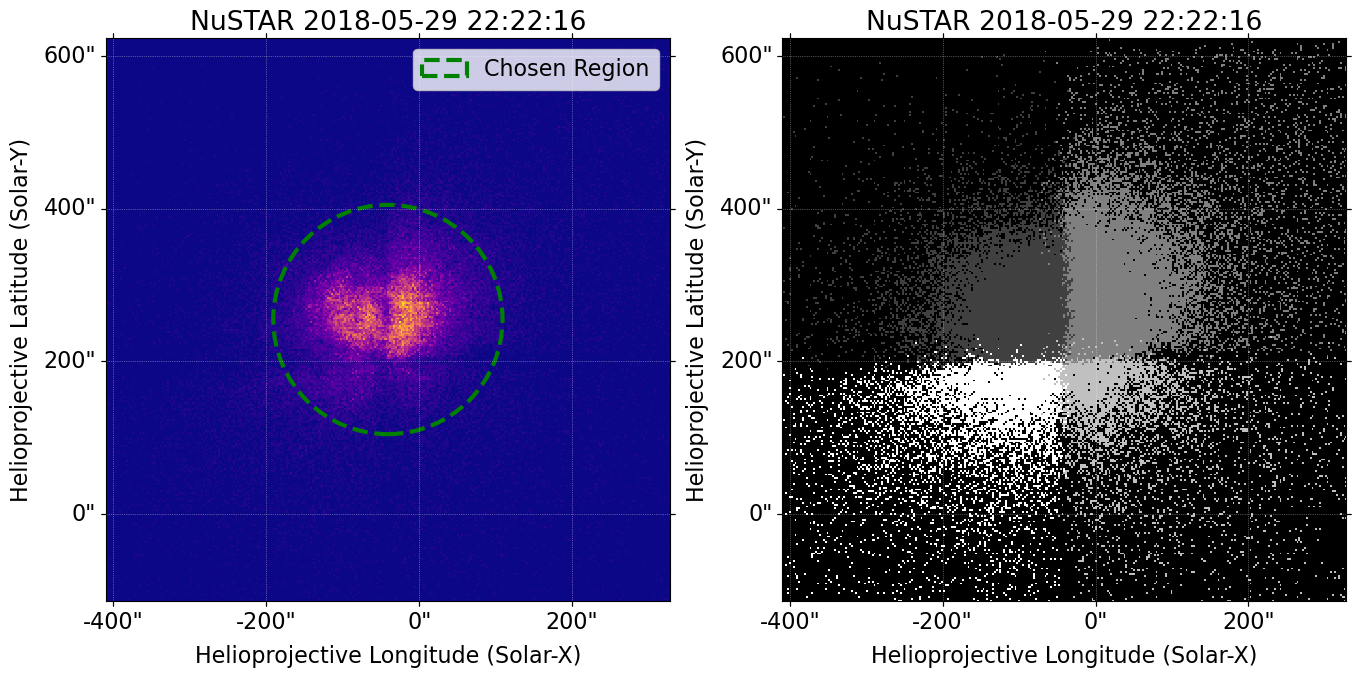

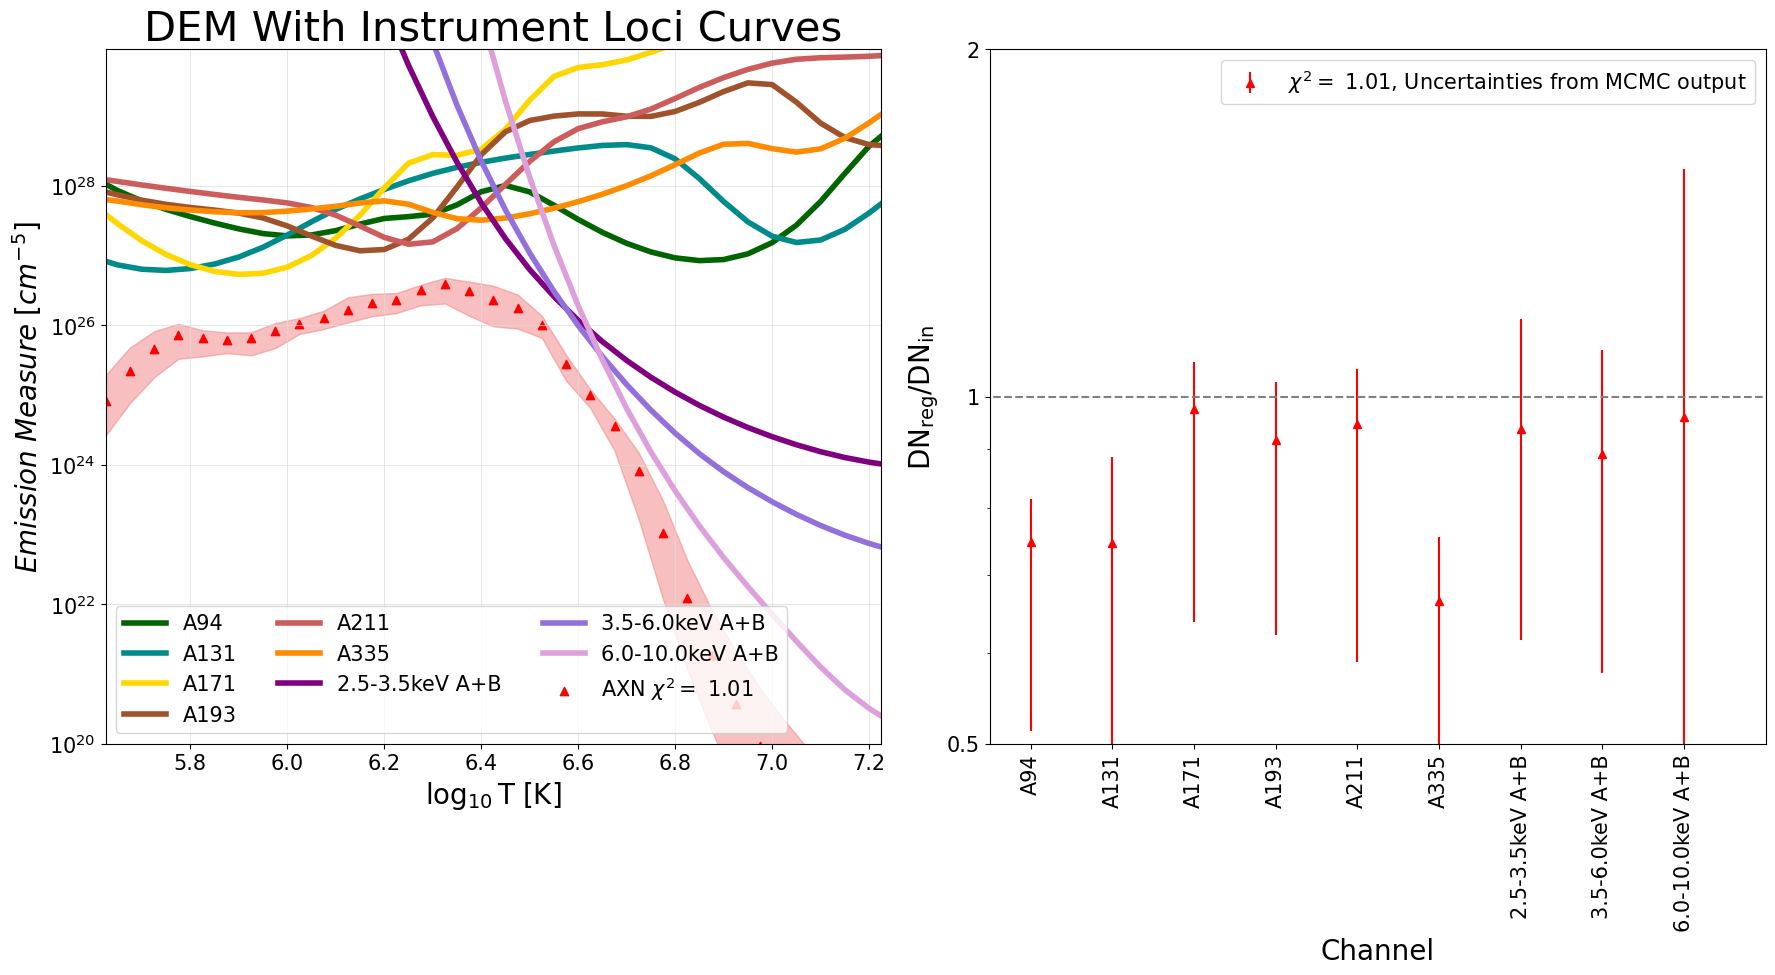

In [8]:
#NuSTAR and AIA DEM
dodem.dodem(time_interval, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
                                    plotMK=plotMK, minT=minT, maxT=maxT,
                                    plotresp=False, working_directory=working_dir,
                                    default_err=0.2, path_to_dodem=path_to_dodem,
            
                                    #demreg related
                                    rgt_fact=1.2, max_iter=30,
                                    reg_tweak=1, gloci=1, mc_in=True, mc_rounds=100, 
                                    
                                    #nustar related 
                                    combine_fpm=True,nuenergies=nuenergies, make_nustar=True, 
                                    datapath=datapath, gtifile=gtifile,
                                    COM_nustar_region=True, nuclobber=False, edit_regfile=True,
            
                                    #aia related
                                    aiamethod='Auto', real_aia_err=True,
                                    input_aia_region="circle", input_aia_region_dict=region_input,
                                       sunpy_dir=sunpy_dir, errortab=errortab)


Adding XRT: this requires a directory (xrt_path) containing level-1 XRT data and grade map files for times/pointings consistent with the NuSTAR data.

Start Time:  2018-05-29T22:22:00.000
Stop Time:  2018-05-29T22:27:00.000
You provided both a region box and a specific region.
Bounding box will be used only for initial data prep (will save submap instead of full disk);
specific region will be used for DEM

Adding 10% error in quadrature with aiapy.estimate_error output.

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing m

['Be-thin', 'Be-med', 'Al-poly']
Adding 10% error in quadrature with real error.

ARF File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001A06_0_p_sr.arf']
RMF File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001A06_0_p_sr.rmf']
PHA File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001A06_0_p_sr.pha']

Max NuSTAR Energy:  28.360000610351562
Highest energy range: [6.0, 10.0]
Total Above:  1
Above Energies:  [28.36000061]
ARF File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001B06_0_p_sr.arf']
RMF File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001B06_0_p_sr.rmf']
PHA File:  ['./initial_dem/22-22-00_22-27-00/nu80410205001B06_0_p_sr.pha']

Max NuSTAR Energy:  6.199999809265137

A94 :     2.93   1.50  51 %
A131 :     23.72   4.23  18 %
A171 :     640.11   66.77  10 %
A193 :     748.56   77.24  10 %
A211 :     272.49   28.74  11 %
A335 :     19.85   2.85  14 %
Be-thin x2 :     36.53   5.03  14 %
Be-med x2 :     6.38   0.88  14 %
Al-poly x2 :     242.28   36.48  15 %
2.5-3.5keV A+B 

'./initial_dem/22-22-00_22-27-00/22-22-00_22-27-00_5.6_7.2_initial_dem_MC_DEM_result.pickle'

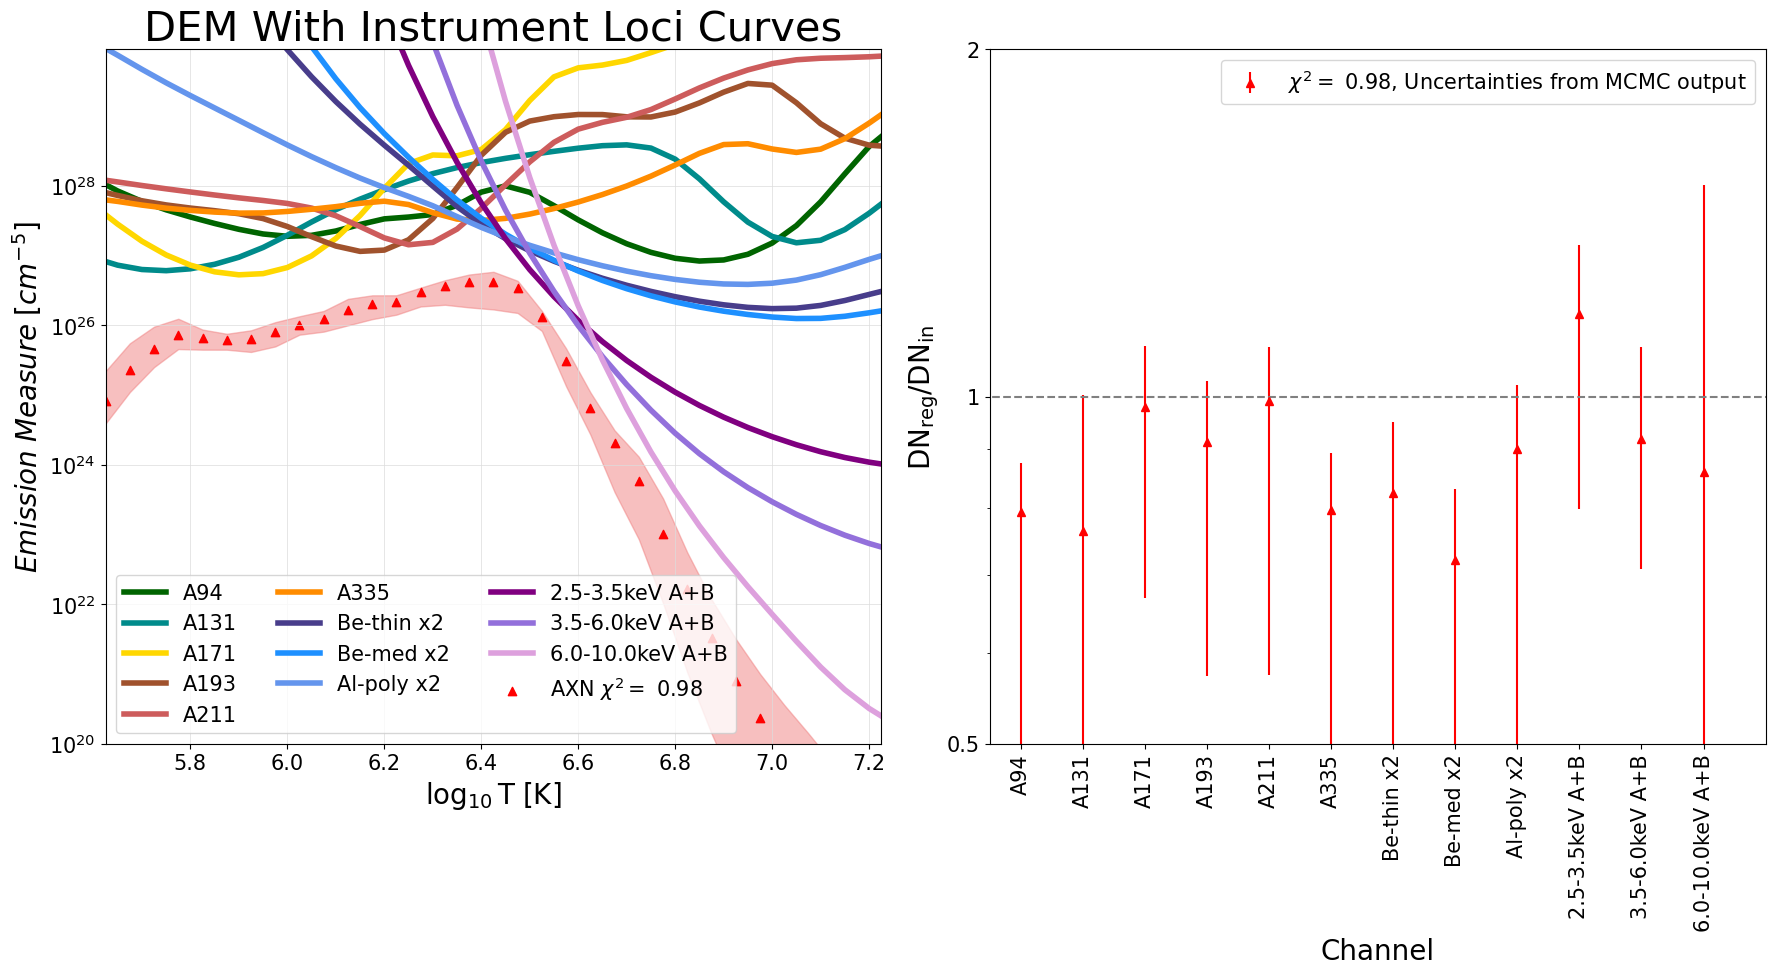

In [10]:
#This is where I'm putting my XRT level-1 data:
xrt_path=working_dir+'/XRT_for_DEM/'
xrt=True
plot_xrt=False

#For this specific example, the automatically generated NuSTAR radius extended outside of the XRT data region. 
#Shifting our AIA/XRT region over to avoid this. (Set plot_xrt=True to check on the location of the region with
#respect to the XRT map; set it False to speed things up.)
region_input = {'center': (xx-32,  yy)*u.arcsec,
                  'radius': rad}

#NuSTAR and AIA DEM
dodem.dodem(time_interval, bl, tr, xrt=xrt, aia=aia, nustar=nustar, name=name,
                                    plotMK=plotMK, plot_xrt=plot_xrt, minT=minT, maxT=maxT,
                                    plotresp=False, working_directory=working_dir,
                                    default_err=0.2, path_to_dodem=path_to_dodem,
            
                                    #demreg related
                                    rgt_fact=1.2, max_iter=30,
                                    reg_tweak=1, gloci=1, mc_in=True, mc_rounds=100, 
                                    
                                    #nustar related 
                                    combine_fpm=True,nuenergies=nuenergies, make_nustar=True, 
                                    datapath=datapath, gtifile=gtifile,
                                    COM_nustar_region=True, nuclobber=False, edit_regfile=True,
            
                                    #aia related
                                    aiamethod='Auto', real_aia_err=True,
                                    input_aia_region="circle", input_aia_region_dict=region_input,
                                       sunpy_dir=sunpy_dir, errortab=errortab,
           
           
                                   #xrt related
                                   xrtmethod='Average', real_xrt_err=True, xrt_path=xrt_path,
                                    xrt_exposure_dict=exposure_dict,
                                    input_xrt_region="circle", input_xrt_region_dict=region_input)

